In [306]:
import os
#from google.colab import userdata
import joblib
import random
import requests
import schedule
import time
from typing import Dict, TypedDict, Union, List, Literal
import json
from datetime import datetime
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import numpy as np
from google import genai
from google.genai import types
# set your own API key
os.environ["API_KEY"] = API_KEY
os.environ["GOOGLE_API_KEY"] = gemini_api_key

In [307]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
client = genai.Client(api_key=gemini_api_key)
class WeatherState(TypedDict):
    city: str
    weather_data: Dict
    disaster_type: str
    fire_prediction:Dict
    severity: str
    response: str
    messages: List[Union[SystemMessage, HumanMessage, AIMessage]]
    alerts: List[str]
    human_approved: bool

In [308]:
def get_weather_data(state: Dict) -> Dict:
    """Fetch weather data from OpenWeatherMap API"""
    BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
    API_KEY = os.getenv("API_KEY")

    request_url = f"{BASE_URL}?appid={API_KEY}&q={state['city']}"

    
    try:
        response = requests.get(request_url)
        response.raise_for_status()
        data = response.json()

        # Date Processing
        dt_unix = data.get("dt", 0)
        dt_obj = datetime.utcfromtimestamp(dt_unix)
        month = dt_obj.month
        year = dt_obj.year

        # Temperature：Kelvin → Fahrenheit
        temp_k = data.get("main", {}).get("temp", 273.15)
        avgtempF = round(temp_k * 9 / 5 - 459.67, 1)

        # Wind Speed m/s → mph
        wind_mps = data.get("wind", {}).get("speed", 0.0)
        wind_mph = round(wind_mps * 2.23694, 2)

        # Snow & Rain（mm → inches）
        snow_mm = data.get("snow", {}).get("3h", 0.0)
        totalSnow = round(snow_mm / 25.4, 2)

        rain_mm = data.get("rain", {}).get("3h", 0.0)
        precip = round(rain_mm / 25.4, 2)

        # Sun Hours
        sunrise = data.get("sys", {}).get("sunrise")
        sunset = data.get("sys", {}).get("sunset")
        sunHour = round((sunset - sunrise) / 3600, 2) if sunrise and sunset else "N/A"


        weather_data = {
            "weather": data.get('weather', [{}])[0].get("description", "N/A"),
            "wind_speed": wind_mph,
            "cloud_cover": data.get("clouds", {}).get("all", "N/A"),
            "sea_level": data.get("main", {}).get("sea_level", "N/A"),
            "temperature": avgtempF,
            "humidity": data.get("main", {}).get("humidity", "N/A"),
            "pressure": data.get("main", {}).get("pressure", "N/A"),
            "avgtempF": avgtempF,
            "totalSnow": totalSnow,
            "precip": precip,
            "sunHour": sunHour,
            "month": month,
            "year": year
        }

        return {
            **state,
            "weather_data": weather_data,
            "messages": state["messages"] + [
                SystemMessage(content=f"Weather data fetched successfully for {state['city']}")
            ]
        }

    except Exception as e:
        error_data = {
            "weather": "N/A", "wind_speed": "N/A", "cloud_cover": "N/A",
            "sea_level": "N/A", "temperature": "N/A", "humidity": "N/A",
            "pressure": "N/A", "avgtempF": "N/A", "totalSnow": "N/A",
            "precip": "N/A", "sunHour": "N/A", "month": "N/A", "year": "N/A"
        }
        return {
            **state,
            "weather_data": error_data,
            "messages": state["messages"] + [
                SystemMessage(content=f"Failed to fetch weather data for {state['city']}: {str(e)}")
            ]
        }

In [309]:
def analyze_disaster_type(state: WeatherState) -> WeatherState:
    """Analyze weather data to identify potential disasters"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Based on the following weather conditions, identify if there's a potential weather disaster.\n"
        "Weather conditions:\n"
        "- Description: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°F\n"
        "- Humidity: {humidity}%\n"
        "- Pressure: {pressure} hPa\n"
        "Categorize into one of these types: Hurricane, Flood, Heatwave, Severe Storm, Winter Storm, or No Immediate Threat"
    )

    try:
        chain = prompt | llm
        disaster_type = chain.invoke(weather_data).content
        return {
            **state,
            "disaster_type": disaster_type,
            "messages": state["messages"] + [SystemMessage(content=f"Disaster type identified: {disaster_type}")]
        }
    except Exception as e:
        return {
            **state,
            "disaster_type": "Analysis Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to analyze disaster type: {str(e)}")]
        }

In [310]:
def get_model_input_from_weather(weather_data: dict) -> list:

    feature_vector = [
        weather_data['avgtempF'],
        weather_data['totalSnow'],
        weather_data['humidity'],
        weather_data['wind_speed'],
        weather_data['precip'],
        weather_data['sunHour'],
        weather_data['year']
    ]

    # One-hot month vector
    current_month = int(weather_data['month'])
    month_one_hot = [1 if m == current_month else 0 for m in range(1, 13)]

    return feature_vector + month_one_hot

In [ ]:
def predict_wildfire(state: WeatherState) -> WeatherState:
    """Predict wildfire risk based on weather data"""
    weather_data = state["weather_data"]
    features=get_model_input_from_weather(weather_data)
    X = np.array(features).reshape(1, -1)
    model=joblib.load('rf_model.joblib')
    label = model.predict(X)[0]
    prob = model.predict_proba(X)[0][1]
    fire_prediction = {
        "label": label,
        "probability": prob
    }
    print(f"Wildfire prediction: {label} with probability {prob:.2f}")
    messages = state["messages"] + [
        SystemMessage(content=f"Wildfire prediction: {label} with probability {prob:.2f}")
    ]
    return {
        **state,
        "fire_prediction": fire_prediction,
        "messages": messages
    }
    

In [312]:
def assess_severity(state: WeatherState) -> WeatherState:
    """Assess the severity of the identified weather situation"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Given the weather conditions and identified disaster type '{disaster_type}', "
        "assess the severity level. Consider:\n"
        "- Weather: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°F\n"
        "Respond with either 'Critical', 'High', 'Medium', or 'Low'"
    )

    try:
        chain = prompt | llm
        severity = chain.invoke({
            **weather_data,
            "disaster_type": state["disaster_type"]
        }).content

        return {
            **state,
            "severity": severity,
            "messages": state["messages"] + [SystemMessage(content=f"Severity assessed as: {severity}")]
        }
    except Exception as e:
        return {
            **state,
            "severity": "Assessment Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to assess severity: {str(e)}")]
        }

In [313]:
def emergency_response(state: WeatherState) -> WeatherState:
    """Generate emergency response plan, enhanced with wildfire prediction context"""
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"]
    city = state["city"]
    fire_pred = state.get("fire_prediction", {}).get("label", 0)
    fire_prob = state.get("fire_prediction", {}).get("probability", None)

    # If no threat，skip
    if disaster in ["no threat", "no immediate threat"]:
        if fire_pred == 1:
            base_prompt=(
            f" AI wildfire model indicates high likelihood of wildfire (probability {fire_prob:.2f}). "
            f"Include specific measures for wildfire containment and evacuation."
        )
        else:
            return {
        **state,
        "response": "No emergency response needed.",
        "messages": state["messages"] + [SystemMessage(content="No immediate threat detected. Emergency response skipped.")]
    }

    # prompt
    else:
        base_prompt = (
        f"Create an emergency response plan for a {disaster} situation "
        f"with {severity} severity level in {city}."
    )

        if fire_pred == 1:
            base_prompt += (
            f" AI wildfire model indicates high likelihood of wildfire (probability {fire_prob:.2f}). "
            f"Include specific measures for wildfire containment and evacuation."
        )

    prompt = ChatPromptTemplate.from_template(base_prompt)

    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": disaster,
            "severity": severity,
            "city": city
        }).content

        messages = state["messages"] + [SystemMessage(content="Emergency response plan generated")]
        if fire_pred == 1:
            messages.append(SystemMessage(content=f"AI wildfire risk detected (probability: {fire_prob:.2f})"))

        return {
            **state,
            "response": response,
            "messages": messages
        }

    except Exception as e:
        return {
            **state,
            "response": "Failed to generate emergency response plan.",
            "messages": state["messages"] + [SystemMessage(content=f"Error generating emergency response: {str(e)}")]
        }

In [314]:
def civil_defense_response(state: WeatherState) -> WeatherState:
    """Generate civil defense response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a civil defense response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on public safety measures."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Civil defense response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate civil defense response: {str(e)}")]
        }

In [315]:
def public_works_response(state: WeatherState) -> WeatherState:
    """Generate public works response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a public works response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on infrastructure protection."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Public works response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate public works response: {str(e)}")]
        }

In [316]:
def give_daily_recommendation(state: WeatherState) -> WeatherState:
    """Provide personalized daily outfit and activity recommendations based on current weather"""
    prompt = ChatPromptTemplate.from_template(
    "You are a friendly local assistant. Based on the following weather data, "
    "provide a personalized recommendation focusing on **health** and **comfort**. "
    "Include:\n"
    "1. Suitable clothing for the weather\n"
    "2. Recommended outdoor or indoor activities\n\n"
    "--Time: {event_time}--\n"
    "- Weather description: {weather_description}\n"
    "- Average temperature (°F): {avgtempF}\n"
    "- Humidity (%): {humidity}\n"
    "- Wind speed (mph): {wind_speed}\n"
    "- Precipitation (inches): {precip}\n"
    "- Sun hours: {sunHour}\n\n"
    "Your advice should help the user stay comfortable and healthy throughout the day. Generate 3-5 sentences."
)

    try:
        weather = state.get("weather_data", {})
        event_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        chain = prompt | llm
        response = chain.invoke({
            "event_time": event_time,
            "weather_description": weather.get("weather", "N/A"),
            "avgtempF": weather.get("avgtempF", "N/A"),
            "humidity": weather.get("humidity", "N/A"),
            "wind_speed": weather.get("wind_speed", "N/A"),
            "precip": weather.get("precip", "N/A"),
            "sunHour": weather.get("sunHour", "N/A")
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Outfit & activity advice generated")]
        }

    except Exception as e:
        return {
            **state,
            "recommendation": "Unable to provide outfit recommendation.",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate outfit advice: {str(e)}")]
        }


In [317]:
def data_logging(state: WeatherState) -> WeatherState:
    """Log weather data, disaster analysis, fire prediction, and response to a file."""
    log_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "city": state["city"],
        "weather_data": state["weather_data"],
        "disaster_type": state["disaster_type"],
        "severity": state["severity"],
        "fire_prediction": state.get("fire_prediction", {}),
        "response": state.get("response", "N/A"),
        "response_triggered": "response" in state and state["response"] not in ["", "No emergency response needed."]
    }

    try:
        with open("disaster_log.txt", "a") as log_file:
            log_file.write(json.dumps(log_data, default=str) + "\n")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Data logged successfully")]
        }
    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to log data: {str(e)}")]
        }


In [318]:
def format_weather_email(state: WeatherState) -> str:
    """Format weather data, disaster analysis, and optional wildfire prediction into an email message"""
    weather = state["weather_data"]
    response_text = state.get("response", "No response generated.")
    fire_pred = state.get("fire_prediction", {})
    fire_label = fire_pred.get("label", 0)
    fire_prob = fire_pred.get("probability", None)

    # Head of the email
    email_content = f"""
 Weather Report and Response for {state['city']}
 Current Weather Conditions:
- Weather: {weather.get('weather', 'N/A')}
- Temperature: {weather.get('temperature', 'N/A')}°F
- Wind Speed: {weather.get('wind_speed', 'N/A')} m/s
- Humidity: {weather.get('humidity', 'N/A')}%
- Pressure: {weather.get('pressure', 'N/A')} hPa
- Cloud Cover: {weather.get('cloud_cover', 'N/A')}%
Response Plan:
{response_text}
Fire Prediction: {'High Risk' if fire_label == 1 else 'Low Risk'} (probability = {fire_prob:.2f}')

Disaster Type: {state['disaster_type']}
Severity Level: {state['severity']}



 
"""

    # Wildfire information (if exist)
    


    email_content += f"\nGenerated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

    return email_content.strip()

In [319]:
def send_email_alert(state: WeatherState) -> WeatherState:
    """Send weather alert email (automated, no human verification)"""
    sender_email = os.getenv("SENDER_EMAIL")
    receiver_email = os.getenv("RECEIVER_EMAIL")
    password = os.getenv("EMAIL_PASSWORD")

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = f"Weather Condition for {state['city']}"

    # 格式化正文
    body = format_weather_email(state)
    print("summary:", body)
    
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()

        print(f"\nEmail sent successfully to {receiver_email} for city: {state['city']}")

        return {
            **state,
            "messages": state["messages"] + [
                SystemMessage(content=f"Email alert sent to {receiver_email} for {state['city']}")
            ],
            "alerts": state.get("alerts", []) + [
                f"Email sent at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
            ]
        }

    except Exception as e:
        print(f"\nFailed to send email: {str(e)}")
        return {
            **state,
            "messages": state["messages"] + [
                SystemMessage(content=f"Failed to send email alert: {str(e)}")
            ]
        }


In [320]:
import re
import wave
from winsound import PlaySound
from playsound import playsound
def extract_disaster_label(disaster_text: str) -> str:
    """Extract clean disaster type from model output."""
    keywords = [
        "Hurricane", "Flood", "Heatwave",
        "Severe Storm", "Winter Storm", "No Immediate Threat"
    ]
    for keyword in keywords:
        if re.search(rf"\b{re.escape(keyword)}\b", disaster_text):
            return keyword
    return "Unknown Threat"
def wave_file(filename, pcm, channels=1, rate=24000, sample_width=2):
   with wave.open(filename, "wb") as wf:
      wf.setnchannels(channels)
      wf.setsampwidth(sample_width)
      wf.setframerate(rate)
      wf.writeframes(pcm)
    
def generate_audio_report(state: WeatherState) -> WeatherState:
    """Generate and save spoken audio report for the weather and disaster response"""

    weather = state.get("weather_data", {})
    city = state.get("city", "Unknown City")
    response_text = state.get("response", "No response available.")
    fire_pred = state.get("fire_prediction", {})
    fire_label = int(fire_pred.get("label", 0))
    fire_prob = fire_pred.get("probability", None)
    severity = state.get("severity", "Unknown")
    disaster_type = extract_disaster_label(state.get("disaster_type", ""))

    fire_text = f"{'High Risk' if fire_label == 1 else 'Low Risk'} (probability = {fire_prob:.2f})" if fire_prob is not None else "N/A"

    tts_text = f"""Weather Report and Response for {city}

Current Weather Conditions:
- Weather: {weather.get('weather', 'N/A')}
- Temperature: {weather.get('temperature', 'N/A')}°F
- Wind Speed: {weather.get('wind_speed', 'N/A')} meters per second
- Humidity: {weather.get('humidity', 'N/A')} percent
- Pressure: {weather.get('pressure', 'N/A')} hectopascals
- Cloud Cover: {weather.get('cloud_cover', 'N/A')} percent

Response Plan:
{response_text}

Fire Prediction: {fire_text}

Disaster Type: {disaster_type}
Severity Level: {severity}
"""

    # Call Gemini to generate speech
    response = client.models.generate_content(
        model="gemini-2.5-flash-preview-tts",
        contents=f"Say clearly: {tts_text}",
        config=types.GenerateContentConfig(
            response_modalities=["AUDIO"],
            speech_config=types.SpeechConfig(
                voice_config=types.VoiceConfig(
                    prebuilt_voice_config=types.PrebuiltVoiceConfig(voice_name='Kore')
                )
            )
        )
    )

    try:
        audio_data = response.candidates[0].content.parts[0].inline_data.data
        wave_file("weather_audio_report.wav", audio_data)
        

# Audio Resport
        playsound("weather_audio_report.wav")
        
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Audio report generated successfully.")]
        }
    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate audio report: {str(e)}")]
        }

In [327]:
def route_response(state: WeatherState) -> Literal[
    "emergency_response",
    "civil_defense_response",
    "public_works_response",
    "give_daily_recommendation"  # Add nodes
]:
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"].strip().lower()

    # Process wildfire model firstly
    fire_pred = state.get("fire_prediction", {}).get("label", 0)
    if fire_pred == 1:
        return "emergency_response"

    if  "no immediate threat" in disaster or "no threat" in disaster:
        return "give_daily_recommendation"

    if severity in ["critical", "high"]:
        return "emergency_response"
    elif "flood" in disaster or "storm" in disaster:
        return "public_works_response"
    else:
        return "civil_defense_response"

In [328]:
# Create the workflow
workflow = StateGraph(WeatherState)

# Add nodes
workflow.add_node("get_weather", get_weather_data)
workflow.add_node("predict_wildfire", predict_wildfire)  # wildfire prediction
workflow.add_node("analyze_disaster", analyze_disaster_type)
workflow.add_node("assess_severity", assess_severity)
workflow.add_node("data_logging", data_logging)
workflow.add_node("generate_audio_report", generate_audio_report)

# Response nodes
workflow.add_node("emergency_response", emergency_response)
workflow.add_node("civil_defense_response", civil_defense_response)
workflow.add_node("public_works_response", public_works_response)
workflow.add_node("give_daily_recommendation", give_daily_recommendation)  # no threat

# Alert
workflow.add_node("send_email_alert", send_email_alert)

# Define edges
workflow.add_edge("get_weather", "predict_wildfire")
workflow.add_edge("predict_wildfire", "analyze_disaster")
workflow.add_edge("analyze_disaster", "assess_severity")
workflow.add_conditional_edges("assess_severity", route_response)

# Conditional dispatch from logging
#workflow.add_conditional_edges("data_logging", route_response)

# Responses → email
workflow.add_edge("emergency_response", "send_email_alert")
workflow.add_edge("civil_defense_response", "send_email_alert")
workflow.add_edge("public_works_response", "send_email_alert")
workflow.add_edge("give_daily_recommendation", "send_email_alert")
workflow.add_edge( "send_email_alert","generate_audio_report")
# Email ends the workflow
workflow.add_edge("generate_audio_report", "data_logging")
workflow.add_edge("data_logging", END)

# Set entry point
workflow.set_entry_point("get_weather")

# Compile
app = workflow.compile()


In [323]:
def run_weather_emergency_system(city: str):
    """Initialize and run the weather emergency system for a given city"""
    initial_state = {
        "city": city,
        "weather_data": {},
        "fire_prediction": {},
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        
        print(f"Completed weather check for {city}")
        return result
    except Exception as e:
        print(f"Error running weather emergency system: {str(e)}")

In [330]:
def main():
    """Run the weather emergency system once, for selected cities"""
    # Set up environment variables
    os.environ["SENDER_EMAIL"] = ""
    os.environ["RECEIVER_EMAIL"] = ""
    os.environ["EMAIL_PASSWORD"] = ""

    cities = ['San Diego']  # can add more cities
    print(f"\nStarting one-time weather check at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    for city in cities:
        try:
            print(f"\nChecking weather conditions for {city}...")
            result = run_weather_emergency_system(city)
            print(f"Completed weather check for {city}")
        except Exception as e:
            print(f"Error checking {city}: {str(e)}")

if __name__ == "__main__":
    main()



Starting one-time weather check at 2025-05-30 15:53:12

Checking weather conditions for San Diego...


Wildfire prediction: 0 with probability 0.12
summary: Weather Report and Response for San Diego
 Current Weather Conditions:
- Weather: scattered clouds
- Temperature: 73.1°F
- Wind Speed: 11.5 m/s
- Humidity: 70%
- Pressure: 1013 hPa
- Cloud Cover: 40%
Response Plan:
Hello! With a pleasant 73°F and scattered clouds, it's a great day to be out and about! I recommend wearing light, breathable clothing like a t-shirt and shorts or a light dress to stay comfortable in the humidity. The light breeze will also feel nice. Consider a brisk walk or bike ride in the park to enjoy the weather and get some exercise, but remember to stay hydrated. If you prefer being indoors, a relaxing yoga session would also be a great option to promote well-being.
Fire Prediction: Low Risk (probability = 0.12')

Disaster Type: Based on the provided weather conditions:

*   **Description:** Scattered clouds indicate generally fair weather.
*   **Wind Speed:** 11.5 m/s (approximately 25.7 mph) is a moderate breez

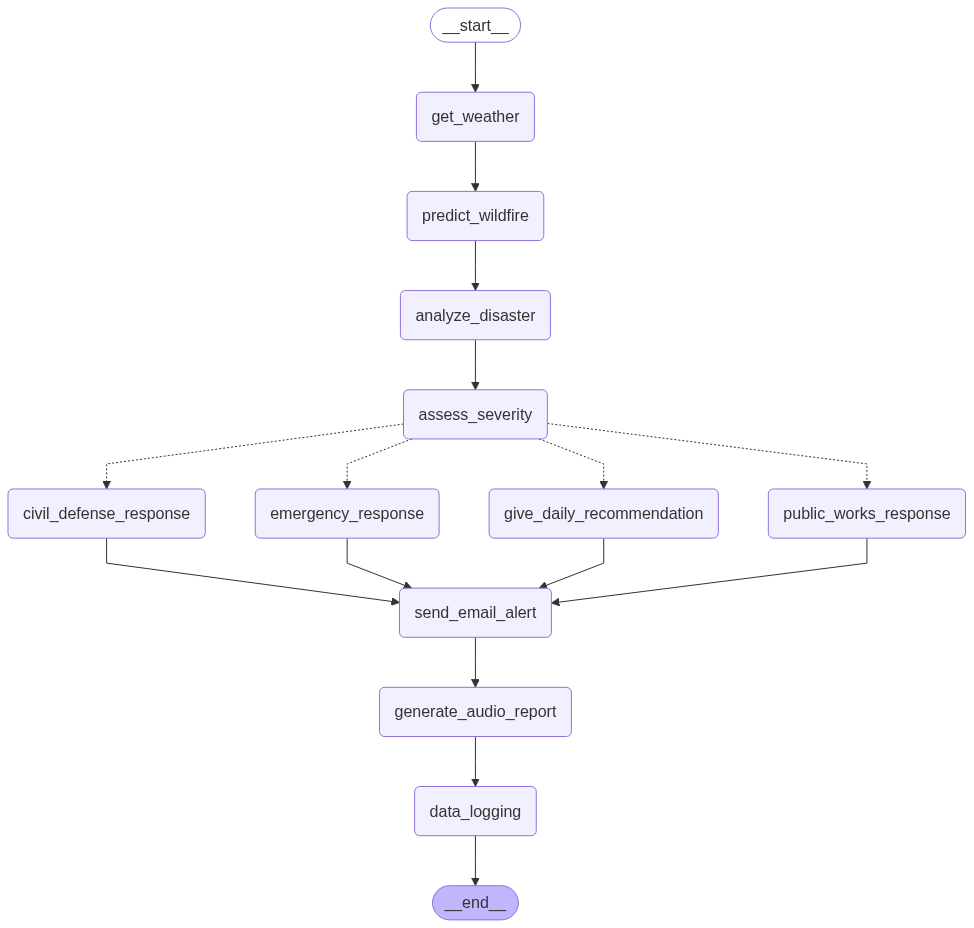

In [329]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass